## David Miranda & Heather Lemon 
### COMP 4448 Tools 2 Final Project Steam 

Dataset Location: 
https://www.kaggle.com/datasets/deepann/80000-steam-games-dataset 


**Steam** is a widely popular video game distribution platform. Currently there are over 50,000 different games 
available for purchase. It was launched as a software client in September 2003 as a way for Valve to provide automatic updates for their games, and expanded to distributing and offering third-party game publishers' titles in late 2005. [0] Steam sales data is not publicly available, but we can use the number of reviews
as a good estimate for units sold this is called the Boxleiter or New Boxleiter number method, estimating the number of Steam game unit sold based on the number of reviews they got. [1][2] For example, a game with 100,000 units sold might have 1,000 reviews on steam. The ratio would therefore be 100,000 / 1,000 = 100.

One very important aspect to keep in mind is the time and price that this data was collected which was two years ago. The metrics and analysis we will perform are from data collected two years ago and will be different that what maybe be currently presented in Steam today. Games could have been removed, sales could have been happening that are no longer available, or the game could be free now.


#### Research Question
Indie game developer Liquid Courage Studios wants to publish a new game called Ace Vendetta and wants to know how much to sell their game for? 

Definition of an Indie game developer is a game published typically with less than 50 developers. In contrast to a AAA game studio with over 100 developers. The biggest difference between the two is size of teams and funding available. Indie games are usually made by companies with less than 30 people, and some are even made by less than five people. On the other hand, AAA games are made by much bigger companies, usually with hundreds of employees. [3]

![steam](steam.png)

In [71]:
import pandas as pd 
import numpy as np
import json
import math
import re
from collections import namedtuple
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn import linear_model
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import r2_score
import statsmodels.api as sm

In [72]:
df = pd.read_csv('steam/steam_data.csv')
print(df.shape)
df.head(3)

(81048, 12)


,url,name,categories,img_url,user_reviews,all_reviews,date,developer,publisher,price,pegi,pegi_url
0,https://store.steampowered.com/app/945360/Amon...,Among Us,Online PvPLAN PvPOnline Co-opLAN Co-opCross-Pl...,https://steamcdn-a.akamaihd.net/steam/apps/945...,"Overwhelmingly Positive(151,281)- 96% of the 1...","Overwhelmingly Positive(224,878)- 95% of the 2...","Nov 16, 2018",Innersloth,Innersloth,Buy Among Us$4.99Add to Cart,-,-
1,https://store.steampowered.com/app/730/Counter...,Counter-Strike: Global Offensive,Steam AchievementsFull controller supportSteam...,https://steamcdn-a.akamaihd.net/steam/apps/730...,"Very Positive(90,780)- 88% of the 90,780 user ...","Very Positive(4,843,904)- 87% of the 4,843,904...","Aug 21, 2012","Valve, Hidden Path Entertainment",Valve,Play Counter-Strike: Global OffensiveFree to P...,-,-
2,https://store.steampowered.com/app/1097150/Fal...,Fall Guys: Ultimate Knockout,MMOOnline PvPOnline Co-opSteam AchievementsFul...,https://steamcdn-a.akamaihd.net/steam/apps/109...,"Very Positive(32,436)- 84% of the 32,436 user ...","Very Positive(223,706)- 80% of the 223,706 use...","Aug 3, 2020",Mediatonic,Devolver Digital,Buy Fall Guys$19.99Add to Cart,-,-


Parse URLS to uuid

In [73]:
url_list = []

def findid(row):
    result = re.search(string=row, pattern=r'\b/[0-9]*/')
    if result is not None:
        result2 = re.sub(string=result.group(0), pattern=r'/*', repl='')
        if result2 is not None:
            url_list.append(result2)

df['url'].apply(lambda x: findid(x))
steam_ids = pd.DataFrame(url_list, columns=['id'])

In [74]:
steam_ids.head()

,id
0,945360
1,730
2,1097150
3,1158310
4,1085660


In [75]:
df = pd.concat([df, steam_ids], join='inner', copy=False, axis=1)
df.head(4)

,url,name,categories,img_url,user_reviews,all_reviews,date,developer,publisher,price,pegi,pegi_url,id
0,https://store.steampowered.com/app/945360/Amon...,Among Us,Online PvPLAN PvPOnline Co-opLAN Co-opCross-Pl...,https://steamcdn-a.akamaihd.net/steam/apps/945...,"Overwhelmingly Positive(151,281)- 96% of the 1...","Overwhelmingly Positive(224,878)- 95% of the 2...","Nov 16, 2018",Innersloth,Innersloth,Buy Among Us$4.99Add to Cart,-,-,945360
1,https://store.steampowered.com/app/730/Counter...,Counter-Strike: Global Offensive,Steam AchievementsFull controller supportSteam...,https://steamcdn-a.akamaihd.net/steam/apps/730...,"Very Positive(90,780)- 88% of the 90,780 user ...","Very Positive(4,843,904)- 87% of the 4,843,904...","Aug 21, 2012","Valve, Hidden Path Entertainment",Valve,Play Counter-Strike: Global OffensiveFree to P...,-,-,730
2,https://store.steampowered.com/app/1097150/Fal...,Fall Guys: Ultimate Knockout,MMOOnline PvPOnline Co-opSteam AchievementsFul...,https://steamcdn-a.akamaihd.net/steam/apps/109...,"Very Positive(32,436)- 84% of the 32,436 user ...","Very Positive(223,706)- 80% of the 223,706 use...","Aug 3, 2020",Mediatonic,Devolver Digital,Buy Fall Guys$19.99Add to Cart,-,-,1097150
3,https://store.steampowered.com/app/1158310/Cru...,Crusader Kings III,Single-playerOnline PvPSteam AchievementsSteam...,https://steamcdn-a.akamaihd.net/steam/apps/115...,"Very Positive(5,359)- 91% of the 5,359 user re...","Very Positive(18,951)- 92% of the 18,951 user ...","Sep 1, 2020",Paradox Development Studio,Paradox Interactive,Buy Crusader Kings III$49.99Add to Cart,BloodLanguagePartial NuditySexual ThemesUse of...,https://steamstore-a.akamaihd.net/public/share...,1158310


The author of the dataset included a final_data_new.json file where they attempt to clean the data from the csv. 
There are 2 problems 1. He didnt include the reviews so we must add that back after cleaning. 
They also did a poor job cleaning the price, which we had to re-do ourselves.

In [76]:
class Field:
    """
    Representational json from steam
    """
    data = []

    def __init__(self):
        self._load_data()

    def _load_data(self) -> None: 
        with open('steam/final_data_new.json', 'r', encoding="utf-8") as file:
            for line in file:
                json_line = json.loads(line,  object_hook=BlankDict)
                for index in range(len(json_line)):
                    if json_line[index]['publisher'] is not None:
                        rec = Record.record(img_url=json_line[index]['img_url'], date=json_line[index]['date'], 
                                            developer=json_line[index]['developer'], publisher=json_line[index]['publisher'], 
                                            full_desc=json_line[index]['full_desc'], 
                                            requirements=json_line[index]['requirements'], popu_tags=json_line[index]['popu_tags'], 
                                            price=json_line[index]['price'], url_info=json_line[index]['url_info'], name=json_line[index]['name'], 
                                            categories=json_line[index]['categories'])
                        self.data.append(rec)
        file.close()

class BlankDict(dict):
    def __missing__(self, key):
        return ''

class Record: 
    """
    Representation of a record
    """
    field = ['img_url', 'date', 'developer', 'publisher', 'full_desc', 'requirements', 'popu_tags', 
             'price', 'url_info', 'name', 'categories']
    record = namedtuple('Record', field)

field = Field()
field.__init__()
print(field.data[0])

Record(img_url='https://steamcdn-a.akamaihd.net/steam/apps/945360/header.jpg?t=1598556351', date='Nov 16, 2018', developer='Innersloth', publisher='Innersloth', full_desc={'sort': 'game', 'desc': "About This Game Play with 4-10 player online or via local WiFi as you attempt to prepare your spaceship for departure, but beware as one or more random players among the Crew are Impostors bent on killing everyone!Originally created as a party game, we recommend playing with friends at a LAN party or online using voice chat. Enjoy cross-platform play between Android, iOS and PC. Win by completing tasks to prepare the ship or ejecting all Impostors. React quickly to undo the Impostor's sabotages. Check the Admin map and Security cameras to keep tabs on other Crewmates. Report any dead bodies immediately to start discussion of who the suspected Impostor is. Call emergency meetings to discuss suspicious behavior. Vote to eject suspected Impostors. Kill crewmates and frame bystanders. Pretend to 

In [77]:
clean_df = pd.DataFrame(field.data, dtype='object', columns=Record.field)
print(clean_df.shape)
clean_df = clean_df.drop_duplicates(subset=['img_url'])

(149642, 11)


In [78]:
clean_df.shape

(64344, 11)

In [79]:
clean_df = pd.concat([clean_df, df[['id']]], axis=1)
clean_df.head(1)

,img_url,date,developer,publisher,full_desc,requirements,popu_tags,price,url_info,name,categories,id
0,https://steamcdn-a.akamaihd.net/steam/apps/945...,"Nov 16, 2018",Innersloth,Innersloth,"{'sort': 'game', 'desc': 'About This Game Play...",{'minimum': {'windows': {'processor': ' SSE2 i...,"[Multiplayer, Online, Space, Social, Deduction...",499,{'url': 'https://store.steampowered.com/app/94...,Among Us,"[Online PvPLAN, PvPOnline Co-opLAN, Co-opCross...",945360


In [80]:
clean_df.reindex()
print(clean_df.shape)

(81047, 12)


In [81]:
clean_df.dtypes

img_url         object
date            object
developer       object
publisher       object
full_desc       object
requirements    object
popu_tags       object
price           object
url_info        object
name            object
categories      object
id              object
dtype: object

In [82]:
clean_df.drop('img_url', inplace=True, axis=1)
clean_df.head(1)

,date,developer,publisher,full_desc,requirements,popu_tags,price,url_info,name,categories,id
0,"Nov 16, 2018",Innersloth,Innersloth,"{'sort': 'game', 'desc': 'About This Game Play...",{'minimum': {'windows': {'processor': ' SSE2 i...,"[Multiplayer, Online, Space, Social, Deduction...",499,{'url': 'https://store.steampowered.com/app/94...,Among Us,"[Online PvPLAN, PvPOnline Co-opLAN, Co-opCross...",945360


In [83]:
clean_df['date'] = pd.to_datetime(clean_df['date'], errors='coerce')
clean_df.head(1)

,date,developer,publisher,full_desc,requirements,popu_tags,price,url_info,name,categories,id
0,2018-11-16,Innersloth,Innersloth,"{'sort': 'game', 'desc': 'About This Game Play...",{'minimum': {'windows': {'processor': ' SSE2 i...,"[Multiplayer, Online, Space, Social, Deduction...",499,{'url': 'https://store.steampowered.com/app/94...,Among Us,"[Online PvPLAN, PvPOnline Co-opLAN, Co-opCross...",945360


In [84]:
clean_df.dtypes

date            datetime64[ns]
developer               object
publisher               object
full_desc               object
requirements            object
popu_tags               object
price                   object
url_info                object
name                    object
categories              object
id                      object
dtype: object

In [85]:
clean_df['price'].head(4)

0     499
1    free
2     199
3     499
Name: price, dtype: object

There is a file called "final_data_new.json" where the price was cleaned, but it is incorrect. So we're cleaning the price here again.

In [86]:
def clean_price(x): 
    result = re.search(pattern=r'[0-9]+\.[0-9][0-9]', string=x)
    if result is None: 
        result = re.search(pattern=r'Free to Play', string=x)
        if result is not None: 
            return 0.00
    if result is not None:
        return result[0]
    else:
        return result

clean_df['clean_price'] = df['price'].apply(lambda x: clean_price(x))
clean_df['clean_price'] = clean_df['clean_price'].astype('float64')
clean_df.drop('price', inplace=True, axis=1)
clean_df.rename(columns={'clean_price': 'price'}, inplace=True)
clean_df.head(3)

,date,developer,publisher,full_desc,requirements,popu_tags,url_info,name,categories,id,price
0,2018-11-16,Innersloth,Innersloth,"{'sort': 'game', 'desc': 'About This Game Play...",{'minimum': {'windows': {'processor': ' SSE2 i...,"[Multiplayer, Online, Space, Social, Deduction...",{'url': 'https://store.steampowered.com/app/94...,Among Us,"[Online PvPLAN, PvPOnline Co-opLAN, Co-opCross...",945360,4.99
1,2012-08-21,"Valve, Hidden Path Entertainment",Valve,"{'sort': 'game', 'desc': 'About This Game Coun...",{'minimum': {'windows': {'processor': ' Intel®...,"[Shooter, Multiplayer, Competitive, Action, Te...",{'url': 'https://store.steampowered.com/app/73...,Counter-Strike: Global Offensive,"[Steam Achievements Full, controller supportSt...",730,0.00
2,2020-08-03,Mediatonic,Devolver Digital,"{'sort': 'game', 'desc': 'About This Game Fall...",{},"[Multiplayer, Funny, Battle, Royale, Online, F...",{'url': 'https://store.steampowered.com/app/10...,Fall Guys: Ultimate Knockout,"[MMOOnline PvPOnline, Co-opSteam Achievements ...",1097150,19.99


In [87]:
clean_df.dtypes

date            datetime64[ns]
developer               object
publisher               object
full_desc               object
requirements            object
popu_tags               object
url_info                object
name                    object
categories              object
id                      object
price                  float64
dtype: object

In [88]:
clean_df.drop(['url_info', 'requirements'], inplace=True, axis=1)

In [89]:
clean_df = pd.concat([clean_df, df[['user_reviews', 'all_reviews']]], axis=1, join='inner')
clean_df.head(3)

,date,developer,publisher,full_desc,popu_tags,name,categories,id,price,user_reviews,all_reviews
0,2018-11-16,Innersloth,Innersloth,"{'sort': 'game', 'desc': 'About This Game Play...","[Multiplayer, Online, Space, Social, Deduction...",Among Us,"[Online PvPLAN, PvPOnline Co-opLAN, Co-opCross...",945360,4.99,"Overwhelmingly Positive(151,281)- 96% of the 1...","Overwhelmingly Positive(224,878)- 95% of the 2..."
1,2012-08-21,"Valve, Hidden Path Entertainment",Valve,"{'sort': 'game', 'desc': 'About This Game Coun...","[Shooter, Multiplayer, Competitive, Action, Te...",Counter-Strike: Global Offensive,"[Steam Achievements Full, controller supportSt...",730,0.00,"Very Positive(90,780)- 88% of the 90,780 user ...","Very Positive(4,843,904)- 87% of the 4,843,904..."
2,2020-08-03,Mediatonic,Devolver Digital,"{'sort': 'game', 'desc': 'About This Game Fall...","[Multiplayer, Funny, Battle, Royale, Online, F...",Fall Guys: Ultimate Knockout,"[MMOOnline PvPOnline, Co-opSteam Achievements ...",1097150,19.99,"Very Positive(32,436)- 84% of the 32,436 user ...","Very Positive(223,706)- 80% of the 223,706 use..."


In [90]:
clean_df.drop_duplicates(subset=['id'], inplace=True)
clean_df.dropna(inplace=True)

In [91]:
clean_df.shape

(46248, 11)

Something to note is price change, there could have been a steam sale that week when the data was initially pulled and 
when you go look at that game today, the price can change it could be cheaper or completely removed. 

Extract All Reviews Number

In [92]:
def getreviewtotal(x):
    """
    Get user and total reviews 
    Params x - the string 
    Return result - str the regex searched string or 0 if there 
    were no reviews found
    """
    result = re.search(pattern=r'^.*\((.*)\)-.*$', string=x)
    if result is not None:
        return result.group(1).replace(",", "")
    else: 
        return None

clean_df['all_review_total'] = clean_df['all_reviews'].apply(lambda x: getreviewtotal(x))
clean_df['user_review_total'] = clean_df['user_reviews'].apply(lambda x: getreviewtotal(x))
clean_df['all_review_total'].astype('float64')
clean_df['user_review_total'].astype('float64')
clean_df.head(4)

,date,developer,publisher,full_desc,popu_tags,name,categories,id,price,user_reviews,all_reviews,all_review_total,user_review_total
0,2018-11-16,Innersloth,Innersloth,"{'sort': 'game', 'desc': 'About This Game Play...","[Multiplayer, Online, Space, Social, Deduction...",Among Us,"[Online PvPLAN, PvPOnline Co-opLAN, Co-opCross...",945360,4.99,"Overwhelmingly Positive(151,281)- 96% of the 1...","Overwhelmingly Positive(224,878)- 95% of the 2...",224878,151281
1,2012-08-21,"Valve, Hidden Path Entertainment",Valve,"{'sort': 'game', 'desc': 'About This Game Coun...","[Shooter, Multiplayer, Competitive, Action, Te...",Counter-Strike: Global Offensive,"[Steam Achievements Full, controller supportSt...",730,0.00,"Very Positive(90,780)- 88% of the 90,780 user ...","Very Positive(4,843,904)- 87% of the 4,843,904...",4843904,90780
2,2020-08-03,Mediatonic,Devolver Digital,"{'sort': 'game', 'desc': 'About This Game Fall...","[Multiplayer, Funny, Battle, Royale, Online, F...",Fall Guys: Ultimate Knockout,"[MMOOnline PvPOnline, Co-opSteam Achievements ...",1097150,19.99,"Very Positive(32,436)- 84% of the 32,436 user ...","Very Positive(223,706)- 80% of the 223,706 use...",223706,32436
3,2020-09-01,Paradox Development Studio,Paradox Interactive,"{'sort': 'game', 'desc': 'About This Game Para...","[Strategy, Simulation, Medieval, Grand, Strate...",Crusader Kings III,"[Single-playerOnline PvPSteam, Achievements St...",1158310,49.99,"Very Positive(5,359)- 91% of the 5,359 user re...","Very Positive(18,951)- 92% of the 18,951 user ...",18951,5359


#### Exploratory Data Analysis

What is the average price of a steam game?

In [93]:
np.around(clean_df['price'].sum()/clean_df['price'].size, 2)

10.99

Average price without free to play?

In [94]:
without_free_price = clean_df[clean_df['price']>0]
np.around(without_free_price['price'].sum()/without_free_price['price'].size, 2)

11.16

Steam recently added a reviews chart and looks like this...

![chart](chart.jpeg)

In [95]:
clean_df.isnull().sum()

date                     0
developer                0
publisher                0
full_desc                0
popu_tags                0
name                     0
categories               0
id                       0
price                    0
user_reviews             0
all_reviews              0
all_review_total     42739
user_review_total    22590
dtype: int64

In [96]:
nullseries = clean_df.isnull().sum()
nullseries = nullseries[nullseries > 0]
print(nullseries)
print("RATIOS")

nullseries.apply(lambda z: print(f"{round((z/clean_df.shape[0])*100, 5)}"))

all_review_total     42739
user_review_total    22590
dtype: int64
RATIOS
92.41264
48.84536


all_review_total     None
user_review_total    None
dtype: object

In [97]:
clean_df.dropna(inplace=True)

In [98]:
clean_df.shape

(3509, 13)

In [99]:
clean_df['all_review_total'] = clean_df['all_review_total'].astype('int64')
clean_df['user_review_total'] = clean_df['user_review_total'].astype('int64')

In [100]:
clean_df.dtypes

date                 datetime64[ns]
developer                    object
publisher                    object
full_desc                    object
popu_tags                    object
name                         object
categories                   object
id                           object
price                       float64
user_reviews                 object
all_reviews                  object
all_review_total              int64
user_review_total             int64
dtype: object

Boxlieter's number

How much you should multiply a game’s review count by in order to estimate number of units sold


In [101]:
Boxlieter = [index for index in range(10,110,10)]
# predicted units sold
def calculate_units_sold(x): 
    units = {}
    for i in Boxlieter: 
        units[i] = (i * x)
    return units 

clean_df['units'] = clean_df['all_review_total'].apply(lambda x: calculate_units_sold(x))

In [102]:
clean_df['units'].head(4)

0    {10: 2248780, 20: 4497560, 30: 6746340, 40: 89...
1    {10: 48439040, 20: 96878080, 30: 145317120, 40...
2    {10: 2237060, 20: 4474120, 30: 6711180, 40: 89...
3    {10: 189510, 20: 379020, 30: 568530, 40: 75804...
Name: units, dtype: object

In [103]:
clean_df['units'][0].items()

dict_items([(10, 2248780), (20, 4497560), (30, 6746340), (40, 8995120), (50, 11243900), (60, 13492680), (70, 15741460), (80, 17990240), (90, 20239020), (100, 22487800)])

### EDA - Numerical 

In [104]:
clean_df.head(1)

,date,developer,publisher,full_desc,popu_tags,name,categories,id,price,user_reviews,all_reviews,all_review_total,user_review_total,units
0,2018-11-16,Innersloth,Innersloth,"{'sort': 'game', 'desc': 'About This Game Play...","[Multiplayer, Online, Space, Social, Deduction...",Among Us,"[Online PvPLAN, PvPOnline Co-opLAN, Co-opCross...",945360,4.99,"Overwhelmingly Positive(151,281)- 96% of the 1...","Overwhelmingly Positive(224,878)- 95% of the 2...",224878,151281,"{10: 2248780, 20: 4497560, 30: 6746340, 40: 89..."


In [105]:
rate_value = []
scaled_units = []
for i in clean_df['units'][0].items():
    rate_value.append(i[0])
    scaled_units.append(i[1])

C:\Users\Heather\AppData\Local\Temp\ipykernel_7696\4175190304.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-talk')


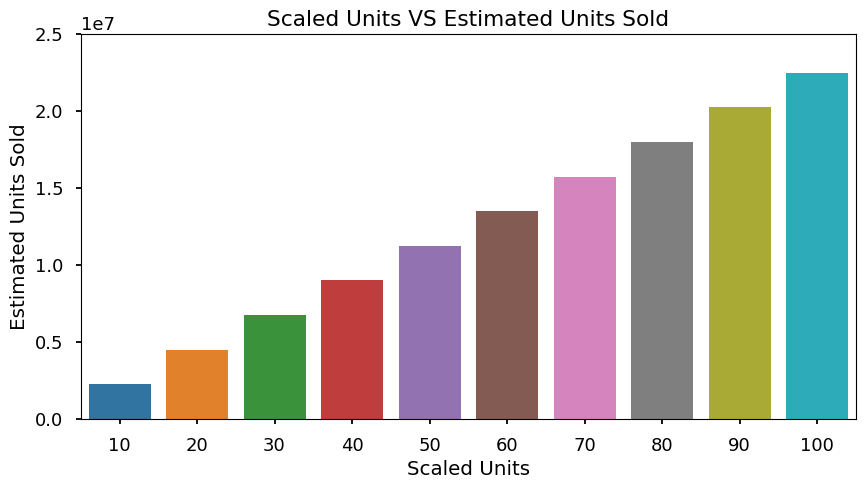

In [106]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.style.use('seaborn-talk')
g = sns.barplot(clean_df, x=rate_value, y=scaled_units);
ax.set_title('Scaled Units VS Estimated Units Sold')
ax.set_xlabel('Scaled Units')
ax.set_ylabel('Estimated Units Sold')

g.set(ylim = (0,25000000))
xlabels = ['{:,.2f}'.format(x) + 'K' for x in g.get_xticks()/1000]

We have a linear relationship between our scaling factor and number of units sold.

In [107]:
year_group = clean_df.groupby(clean_df.date.dt.year).mean()
year_group.head(4)

C:\Users\Heather\AppData\Local\Temp\ipykernel_7696\3377804675.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  year_group = clean_df.groupby(clean_df.date.dt.year).mean()


,price,all_review_total,user_review_total
date,,,
1984,9.99,484.0,11.0
1989,1.99,656.0,28.0
1990,14.99,767.0,13.0
1991,19.99,623.0,12.0


C:\Users\Heather\AppData\Local\Temp\ipykernel_7696\3404108856.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=year_group.index, rotation=45, ha='center')


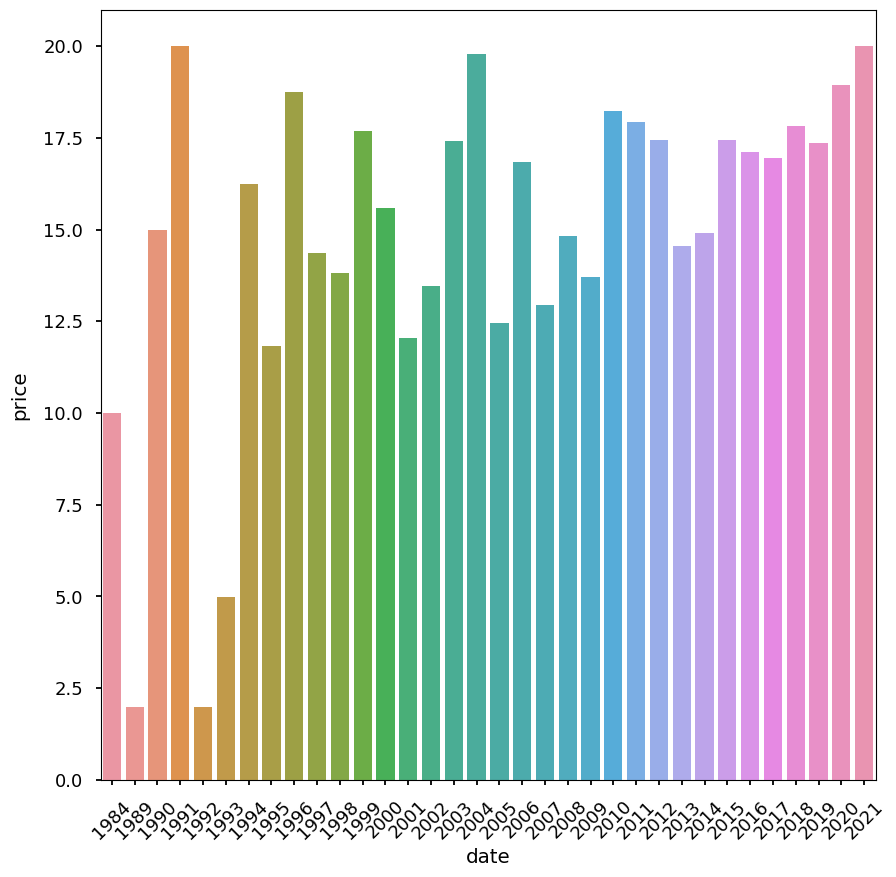

In [108]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_ylabel(ylabel='Average Price', labelpad=10)
ax.set_xlabel(xlabel='Year')
ax.set_xticklabels(labels=year_group.index, rotation=45, ha='center')
sns.barplot(x=year_group.index, y=year_group['price'], ax=ax);

In [109]:
feature_matrix = sm.add_constant(year_group, prepend=False)
feature_matrix = feature_matrix.reset_index()
X = feature_matrix[['all_review_total', 'user_review_total', 'date']]
y = feature_matrix[['price']]
model = sm.OLS(y, X)
multiple_lr = model.fit()
print(multiple_lr.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.924
Model:                            OLS   Adj. R-squared (uncentered):              0.916
Method:                 Least Squares   F-statistic:                              124.9
Date:                Thu, 02 Mar 2023   Prob (F-statistic):                    2.15e-17
Time:                        15:18:01   Log-Likelihood:                         -97.688
No. Observations:                  34   AIC:                                      201.4
Df Residuals:                      31   BIC:                                      206.0
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

There is a strong correlation between how many reviews a game gets and how many units they’ve sold. However, this ratio does depend on other factors – game’s release year, popularity and even price. [2] With an R2 of over 90% there exists strong correlations between price and reviews. 

Here we're scoping down the issue to filter on only Indie made games with tag "Indie" from the popu_tags column.

In [110]:
clean_df = clean_df[clean_df['popu_tags'].astype(str).str.contains("Indie") == True]
print(clean_df.shape)
clean_df.head(1)

(1588, 14)


,date,developer,publisher,full_desc,popu_tags,name,categories,id,price,user_reviews,all_reviews,all_review_total,user_review_total,units
0,2018-11-16,Innersloth,Innersloth,"{'sort': 'game', 'desc': 'About This Game Play...","[Multiplayer, Online, Space, Social, Deduction...",Among Us,"[Online PvPLAN, PvPOnline Co-opLAN, Co-opCross...",945360,4.99,"Overwhelmingly Positive(151,281)- 96% of the 1...","Overwhelmingly Positive(224,878)- 95% of the 2...",224878,151281,"{10: 2248780, 20: 4497560, 30: 6746340, 40: 89..."


In [111]:
bins = [0, 10, 15, 20]
price_group = clean_df.groupby([clean_df.date.dt.year, pd.cut(clean_df.price, bins)])
print(price_group.size().unstack())

price  (0, 10]  (10, 15]  (15, 20]
date                              
1997         1         0         0
1998         1         0         0
2001         3         0         0
2003         0         0         1
2004         0         0         0
2006         1         1         0
2007         0         1         0
2008         3         0         0
2009         2         0         1
2010         1         1         1
2011         3         1         4
2012         7         7         6
2013        17         6         7
2014        36        10        11
2015        37        22        22
2016        67        26        26
2017        90        30        55
2018        93        37        47
2019       123        64        68
2020       117        47        80


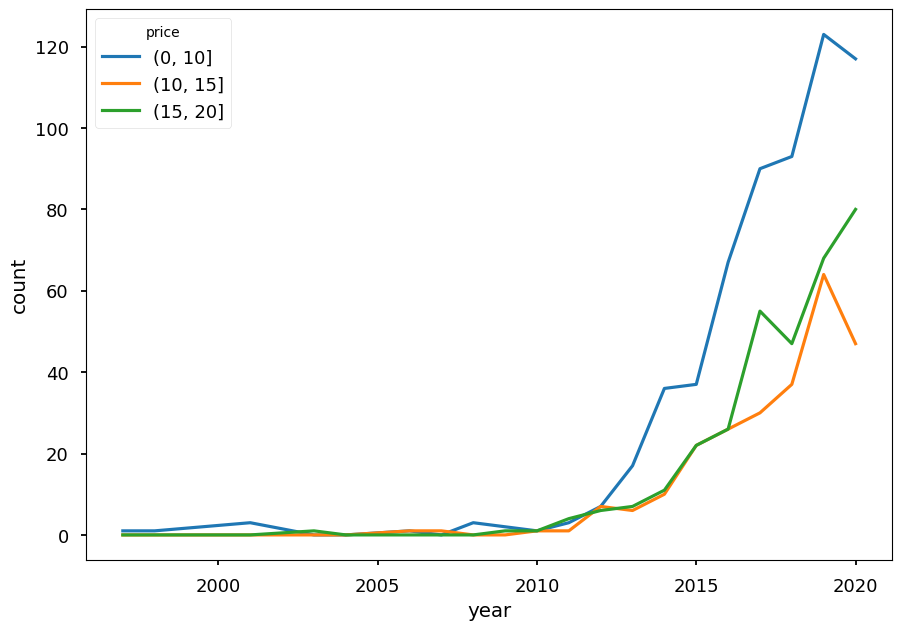

In [112]:
price_group.size().unstack().plot(xlabel="year", ylabel="count");

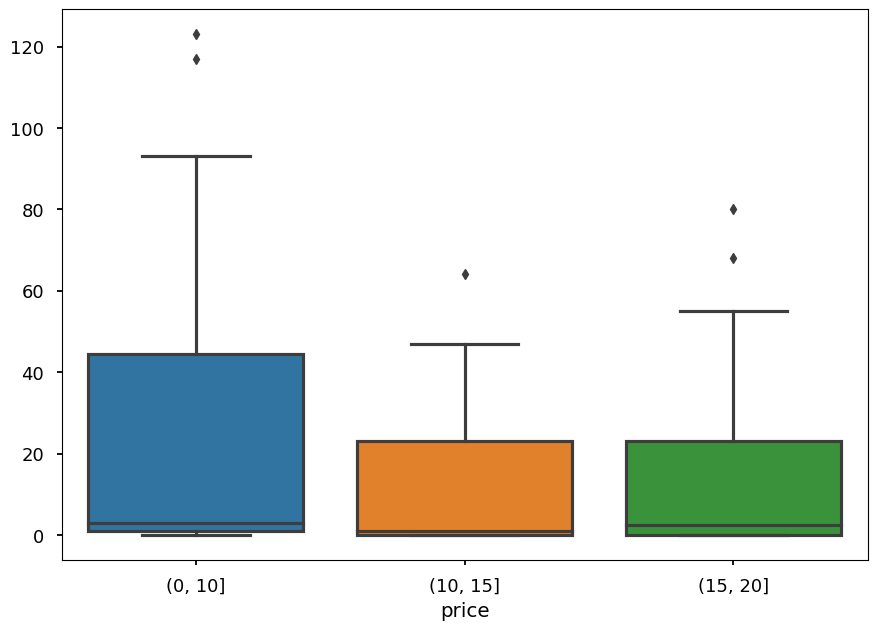

In [113]:
sns.boxplot(price_group.size().unstack());

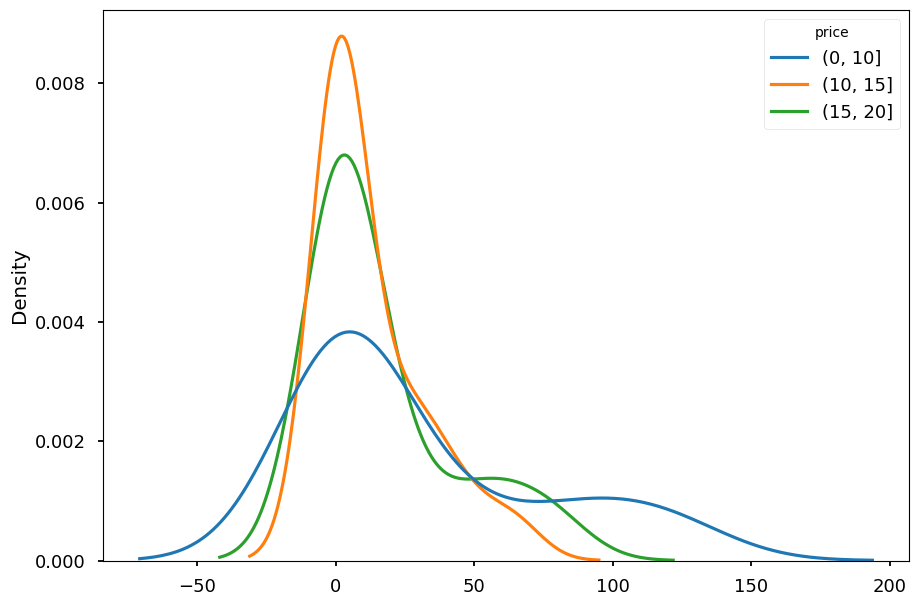

In [114]:
sns.kdeplot(price_group.size().unstack());

### Model Pre-processing

In [115]:
clean_df.drop(['date', 'id', 'user_reviews', 'all_reviews'], inplace=True, axis=1)

In [116]:
categorical_df = clean_df[['full_desc', 'popu_tags', 'categories', 'developer', 'publisher', 'name']]
clean_df.drop(['full_desc', 'popu_tags', 'categories', 'developer', 'publisher', 'name'], inplace=True, axis=1)

In [117]:
clean_df.head(1)

,price,all_review_total,user_review_total,units
0,4.99,224878,151281,"{10: 2248780, 20: 4497560, 30: 6746340, 40: 89..."


convert dict to header/value pairs

In [118]:
units_df = pd.DataFrame.from_records(data=clean_df.units, columns=[index for index in range(10,110,10)])
clean_df = pd.concat([clean_df, units_df], axis=1)
clean_df.drop('units', inplace=True, axis=1)
clean_df.dropna(inplace=True)
print(clean_df.shape)
print(clean_df.dtypes)
clean_df.head(1)

(414, 13)
price                float64
all_review_total     float64
user_review_total    float64
10                   float64
20                   float64
30                   float64
40                   float64
50                   float64
60                   float64
70                   float64
80                   float64
90                   float64
100                  float64
dtype: object


,price,all_review_total,user_review_total,10,20,30,40,50,60,70,80,90,100
0,4.99,224878.0,151281.0,2248780.0,4497560.0,6746340.0,8995120.0,11243900.0,13492680.0,15741460.0,17990240.0,20239020.0,22487800.0


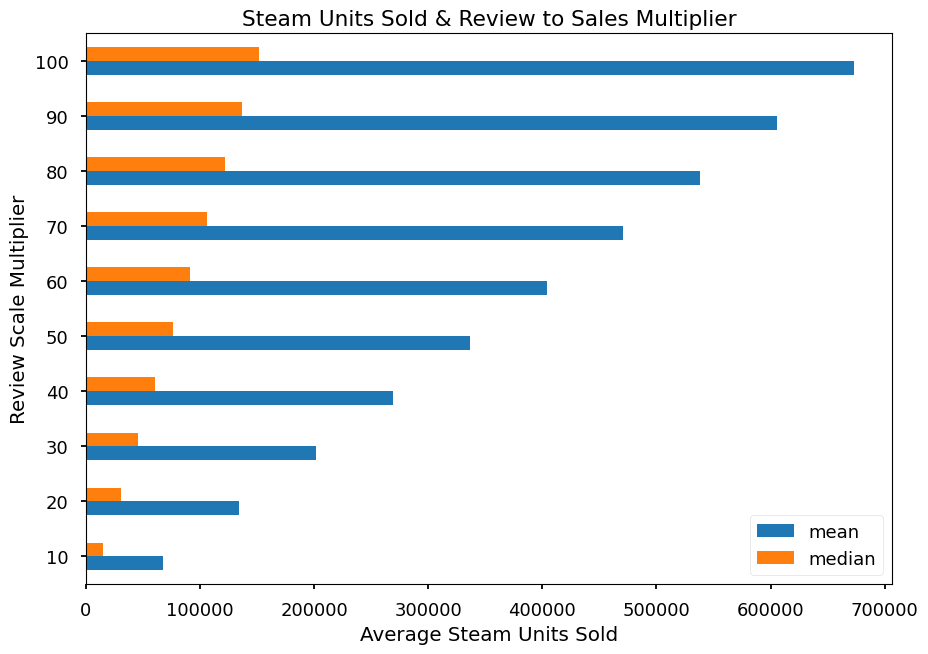

In [119]:
calc_result = clean_df.apply(['mean', 'median'])
calc_result.drop(['price', 'all_review_total', 'user_review_total'], axis=1, inplace=True)

g = calc_result.T.plot.barh(title='Steam Units Sold & Review to Sales Multiplier')
g.set_xlabel('Average Steam Units Sold')
g.set_ylabel('Review Scale Multiplier');

There are exceptions to this rule. For example, Elden Ring, which recently hit 17.5 million units sold across all platforms, has over 400,000 reviews on Steam. “It’s likely this is because Elden Ring is a ‘game that people want to talk about’ — with >90% Positive reviews,” Carless noted. “And so 1 in 20-25 players leave a review, compared to the 1 in 50-60 that is more normal with a large-scale game.” Which equtes to a <span style="color:red">350</span> scaled multiplier! [1]

Check the target distribution rate

what is the estimated number of units sold at the median price of indie games?

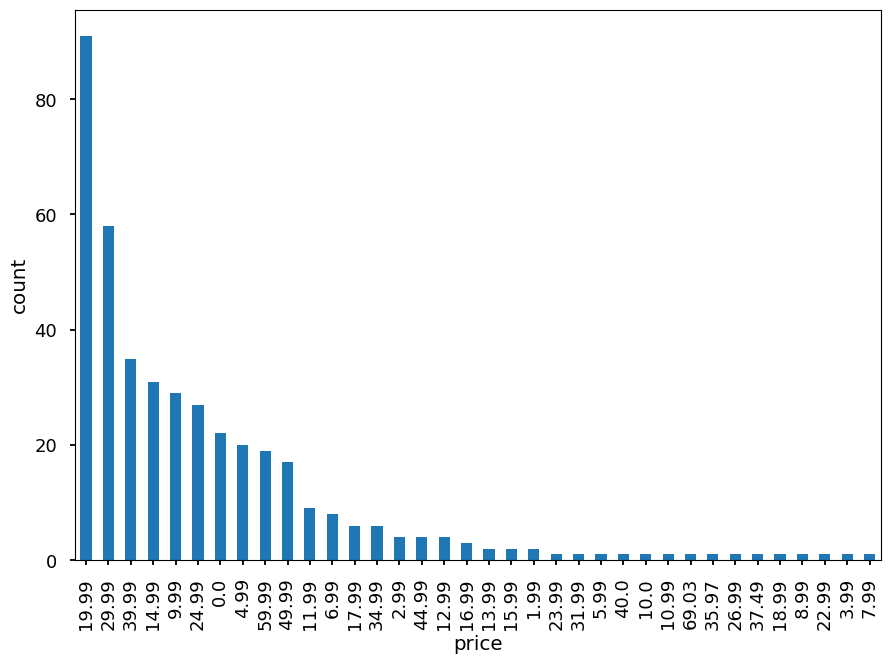

In [138]:
clean_df['price'].value_counts().plot.bar(ylabel='count', xlabel='price');

In [120]:
median_price = clean_df.apply(['median', 'mean', 'std'])
median_price

,price,all_review_total,user_review_total,10,20,30,40,50,60,70,80,90,100
median,19.990000,5775.000000,136.000000,15180.000000,30360.000000,45540.000000,6.072000e+04,7.590000e+04,9.108000e+04,1.062600e+05,1.214400e+05,1.366200e+05,1.518000e+05
mean,23.363816,24727.178744,970.021739,67271.932367,134543.864734,201815.797101,2.690877e+05,3.363597e+05,4.036316e+05,4.709035e+05,5.381755e+05,6.054474e+05,6.727193e+05
std,14.831215,83346.231652,7736.449473,309887.323509,619774.647017,929661.970526,1.239549e+06,1.549437e+06,1.859324e+06,2.169211e+06,2.479099e+06,2.788986e+06,3.098873e+06


In [136]:
median_price.price['median']

19.99

In [158]:
median_price.iloc[0, 3:]

10      15180.0
20      30360.0
30      45540.0
40      60720.0
50      75900.0
60      91080.0
70     106260.0
80     121440.0
90     136620.0
100    151800.0
Name: median, dtype: float64

In [164]:
clean_df.head(1)

,price,all_review_total,user_review_total,10,20,30,40,50,60,70,80,90,100
0,4.99,224878.0,151281.0,2248780.0,4497560.0,6746340.0,8995120.0,11243900.0,13492680.0,15741460.0,17990240.0,20239020.0,22487800.0


### Scaling & Split the data before Model Selection

In [50]:
y = clean_df[['price']]
y = np.ravel(y)
clean_df.drop('price', inplace=True, axis=1)

X = clean_df
X.columns = X.columns.astype(str)

In [51]:
# minmax = MinMaxScaler()
# scaled_arr = minmax.fit_transform(X)
# scaled_y = minmax.fit_transform(y.reshape(-1, 1))


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=0)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train[:1], y_test[:1])

(331, 12)
(83, 12)
(331,)
(83,)
[39.99] [0.]


### Model Selection

* Linear Regression
* DecisionTree Regressor
* Random Forest Regressor
* Bayesian Ridge
* SVM-R
* Bagging Regressor

In [52]:
prettytable = PrettyTable(field_names=["Model", "Score"])

lr = LinearRegression()
lr_model = lr.fit(x_train, y_train)
lr_train_pred = lr_model.predict(x_train)
print(lr_train_pred[:5])

mse = mean_squared_error(y_train, lr_train_pred)
r_squared = lr_model.score(x_train, y_train)
print("Coefficients: \n", lr_model.coef_)
print('MSE:', mse)
print('R2:', r_squared)

prettytable.add_row(['Linear Regression', round(lr_model.score(X=x_train, y=y_train), 5)])

[23.41210188 23.2438075  23.40012244 23.38696612 23.15668934]
Coefficients: 
 [ 2.85801281e-07 -1.01749321e-04 -4.56472906e-09 -9.12945813e-09
 -1.36941872e-08 -1.82589163e-08 -2.28236453e-08 -2.73883744e-08
 -3.19531035e-08 -3.65178325e-08 -4.10825616e-08 -4.56472906e-08]
MSE: 211.03845888296513
R2: 0.005824409933302244


In [53]:
dt_r = DecisionTreeRegressor(random_state=0)
dt_r = dt_r.fit(x_train, y_train)
dtr_y_pred = dt_r.predict(x_train)
print(dtr_y_pred[:5])

prettytable.add_row(['Decision Tree Regressor', round(dt_r.score(x_train, y_train), 5)])

[39.99 39.99 19.99 34.99 59.99]


In [54]:
rfr = RandomForestRegressor(n_estimators=100, random_state=0)
rfr = rfr.fit(x_train, y_train)
rfr_pred = rfr.predict(x_train)
print(rfr_pred[:5])

prettytable.add_row(['Random Forest Regressor', round(rfr.score(x_train, y_train), 5)])

[34.6    34.6407 23.0702 33.55   49.5204]


In [55]:
b_ridge = linear_model.BayesianRidge()
b_ridge = b_ridge.fit(x_train, y_train)
bridge_pred = b_ridge.predict(x_train)
print(bridge_pred[:5])

prettytable.add_row(['Bayesian Ridge', round(b_ridge.score(x_train, y_train), 5)])

[23.41349671 23.24079455 23.40117747 23.38807159 23.15500568]


In [56]:
regr_svm = svm.SVR()
regr_svm.fit(x_train, y_train)
regr_svm_pred = regr_svm.predict(x_train)
print(regr_svm_pred[:5])

prettytable.add_row(['SVM Regressor', round(regr_svm.score(x_train, y_train), 5)])

[20.03905828 20.75807641 20.03717622 20.03875288 20.84500801]


In [57]:
bgr = BaggingRegressor()

bgr = bgr.fit(x_train, y_train)
bgr_pred = bgr.predict(x_train)
print(bgr_pred[:5])

prettytable.add_row(['Bagging Regessor', round(bgr.score(x_train, y_train), 5)])

[34.69  30.491 26.588 35.49  45.29 ]


In [58]:
prettytable

Model,Score
Linear Regression,0.00582
Decision Tree Regressor,1.0
Random Forest Regressor,0.83423
Bayesian Ridge,0.00582
SVM Regressor,-0.03207
Bagging Regessor,0.76341


The decision tree regessor is overfitting, with random forest and bagging regressor following close behind.

### Select top 3 performing models and begin hyperparameter tuning

In [59]:
scores_dtr = cross_val_score(estimator=dt_r, X=x_train, y=y_train, cv=5, error_score='raise')
scores_rfr = cross_val_score(estimator=rfr, X=x_train, y=y_train, cv=5, error_score='raise')
scores_bag = cross_val_score(estimator=bgr, X=x_train, y=y_train, cv=5, error_score='raise')

pretty2table = PrettyTable()

pretty2table.add_row(["Decision Tree Regressor", sorted(np.sqrt(-scores_dtr), reverse=True)])
pretty2table.add_row(["Random Forest Regressor", sorted(np.sqrt(-scores_rfr), reverse=True)])
pretty2table.add_row(["Bagging Regressor", sorted(np.sqrt(-scores_bag), reverse=True)])

pretty2table

Field 1,Field 2
Decision Tree Regressor,"[1.3518212790656936, 1.1904388724191948, 0.9195993629506242, 0.9120486235039619, 0.8174282786432167]"
Random Forest Regressor,"[0.4954454637105947, 0.48378853653737025, 0.4670692198071704, 0.4534584936408116, 0.3221420835468982]"
Bagging Regressor,"[0.6395775750237541, 0.5762126120277683, 0.555936386251624, 0.4866353706218054, 0.450907505463891]"


Our best model from the top three was Decision Tree Regressor.

In [60]:
param_grid_search = [
    {'criterion': ['friedman_mse', 'squared_error', 'absolute_error', 'poisson']},
    {'splitter': ['best', 'random']}, 
    {'max_depth': [1, 3, 5, 8]},
    {'min_samples_split': [2, 5, 10]}, 
    {'min_samples_leaf': [1, 2, 4]}, 
    {'max_features': ['auto', 'sqrt', 'log2']},
]

grid_search = GridSearchCV(estimator=dt_r, cv=8, param_grid=param_grid_search, error_score='raise', verbose=3, n_jobs=10)

dt_model = grid_search.fit(x_train, y_train)

dt_score = dt_model.score(X=x_train, y=y_train)

pretty4table = PrettyTable(field_names=['Grid Search CV', 'Score'])

pretty4table.add_row(["Grid Search CV", dt_score])

pretty4table

Fitting 8 folds for each of 19 candidates, totalling 152 fits


Grid Search CV,Score
Grid Search CV,0.013878829230704715


In [61]:
dt_model.best_estimator_

DecisionTreeRegressor(max_depth=1, random_state=0)

In [62]:
dt_model.best_params_

{'max_depth': 1}

In [63]:
dt_model.best_score_

-0.07597975786568609

In [64]:
best_dt_scores = cross_val_score(estimator=dt_model.best_estimator_, X=x_train, y=y_train)
best_dt_scores

array([-0.06044802, -0.02286809, -0.05066173, -0.31262389, -0.07766112])

In [65]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(x_train)

r2 = r2_score(y_train, predictions)
mse = mean_squared_error(y_train, predictions)
rmse = np.sqrt(mse)

print("Compare Training Best Estimator Scores:")
print("R2 Score: %.2f" % r2)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)

Compare Training Best Estimator Scores:
R2 Score: 0.01
MSE: 209.33
RMSE: 14.47


In [66]:
final_predictions = best_model.predict(x_test)
final_predictions[:5]

array([23.5686875, 23.5686875, 23.5686875, 23.5686875, 23.5686875])

In [67]:
print("Final Price Prediction: ", math.floor(np.mean(final_predictions)))

Final Price Prediction:  22


In [68]:
final_r2 = r2_score(y_test, final_predictions)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print("Final Scores:")
print("R2 Score: %.2f" % final_r2)
print("MSE: %.2f" % final_mse)
print("RMSE: %.2f" % final_rmse)

Final Scores:
R2 Score: -0.08
MSE: 266.45
RMSE: 16.32


Answering our research question shows that Liquid Courage Studios should market their Indie game on Steam for $22.00

We can confirm our accuracy through this third party website that tracks steam game unit sale estimations. https://steamdb.info/app/990080/charts/

The most important feature in predicting price and if the game will sell well is timing. Timing is everything. 
It's also dependent upon Early Access, DLC, and genre. 

Other metrics to look at in the future include computer requirements, total number of active players, follower count, and times when other similar games go on sale. 

### References

* [0] https://www.valvesoftware.com/en/about  
* [1] https://gameworldobserver.com/2022/11/15/how-to-count-game-sales-steam-2022-review-multiplier 
* [2] https://vginsights.com/insights/article/further-analysis-into-steam-reviews-to-sales-ratio-how-to-estimate-video-game-sales 
* [3] https://hub.packtpub.com/difference-between-working-indie-and-aaa-game-development/ 